In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 100

import geopandas as gpd

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, offline
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import requests

from os import listdir
import unicodedata

import json

from paths import *
from tools.vizu import remove_acentos
from tools.vizu import normalize_cols
from tools.io import read_sheets


from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')


# Brasil.IO

In [2]:
####### IMPORT DATA ######
url = 'https://brasil.io/api/dataset/covid19/caso/data?format=json'
df_final = pd.DataFrame()

while url != None:
    
    print(url)
    response = requests.get(url)
    data = response.text
    parsed = json.loads(data)
    url = parsed['next']
    df = pd.DataFrame(parsed['results']).sort_values(by='confirmed',ascending=False)
    df_final = pd.concat([df_final,df], axis=0)

https://brasil.io/api/dataset/covid19/caso/data?format=json
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=2
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=3


In [3]:
df_final.head(10)

,city,city_ibge_code,confirmed,confirmed_per_100k_inhabitants,date,death_rate,deaths,estimated_population_2019,is_last,order_for_place,place_type,state
257,None,35,1451,3.15991,2020-03-29,0.0675,98.0,45919049.0,True,31,state,SP
535,None,35,1406,3.06191,2020-03-28,0.0597,84.0,45919049.0,False,30,state,SP
844,None,35,1223,2.66338,2020-03-27,0.0556,68.0,45919049.0,False,29,state,SP
835,São Paulo,3550308,1044,8.52104,2020-03-27,0.0594,62.0,12252023.0,True,25,city,SP
429,None,33,558,3.23198,2020-03-28,0.0233,13.0,17264943.0,True,16,state,RJ
709,None,33,493,2.85550,2020-03-27,0.0203,10.0,17264943.0,False,15,state,RJ
425,Rio de Janeiro,3304557,489,7.27797,2020-03-28,0.0184,9.0,6718903.0,True,15,city,RJ
705,Rio de Janeiro,3304557,431,6.41474,2020-03-27,0.0139,6.0,6718903.0,False,14,city,RJ
996,None,33,421,2.43847,2020-03-26,0.0214,9.0,17264943.0,False,14,state,RJ
992,Rio de Janeiro,3304557,368,5.47708,2020-03-26,0.0163,6.0,6718903.0,False,13,city,RJ


## transformation

In [4]:
from tools.manipulation import create_br_not_sp

df = df_final.sort_values(by='confirmed',ascending=False)
dd = create_br_not_sp(df)

### GET ONLY LAST DAY
mask = dd['date'] < today
dd = dd[mask]

dd = dd.sort_values(by=['date'],ascending=False)
dd = dd.sort_values(by=['confirmed'],ascending=False)

# get only the states
mask = ((dd['place_type']!='city'))
df_states = dd[mask]
df_states = df_states.sort_values(by=['date'],ascending=False)

# Import Data

In [24]:
df = pd.read_csv('https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv')
df['state'] = df['state'].str.replace('TOTAL','BRASIL')
df.to_csv('brasil_states.csv', index=False)
dd = df.copy()

In [25]:
dd = dd.drop(['country','deaths'],1)

In [26]:
# dd.tail(30)

## MYTABLE

In [43]:
from tools.io import read_sheets
df = read_sheets('covid19_estados')

In [44]:
# ddf = pd.merge(dd , df, on=['date','state'], how='left')
# ddf['confirmed'] = ddf['totalCases']
# ddf['new_cases'] = ddf['newCases']
# ddf = ddf.drop(['city','newCases','totalCases'],1)
# df  = ddf.copy()

In [45]:
for col in ['confirmed','new_cases','deaths','new_deaths']:
    df[col] = pd.to_numeric(df[col])

In [46]:
# mask = df['new_deaths'].notnull()
# df = df[mask]

In [47]:
df_states = df.sort_values(by=['date','confirmed'], ascending=False)
df_states['city'] = df_states['state']
df_states.head()

mask = (df_states['state']!='BRASIL') & (df_states['state']!='SP')
not_sp = df_states[mask].groupby(by=['date'], as_index=False).sum()

not_sp['state'] = 'EXCETO SP'
not_sp['city'] = 'EXCETO SP'
df_states = pd.concat([df_states,not_sp[df_states.columns]],axis=0)


## VIS

In [52]:
from tools.vizu import brasil_vis
df_states = df_states.sort_values(by=['date'],ascending=False)

escala  = 'lin'
largura = None
save    = True
#### CHOSE CITIES TO START SELECTED IN GRAPH
in_cities = ['BRASIL','SP', 'RJ','EXCETO SP']

# mask = ((dd[var_col]>0))
# dd = dd[mask]

## confirmed or deaths
for var in ['deaths','confirmed']:
    fig = brasil_vis(df_states, var,in_cities, escala, today='30/03/2020', save=True)

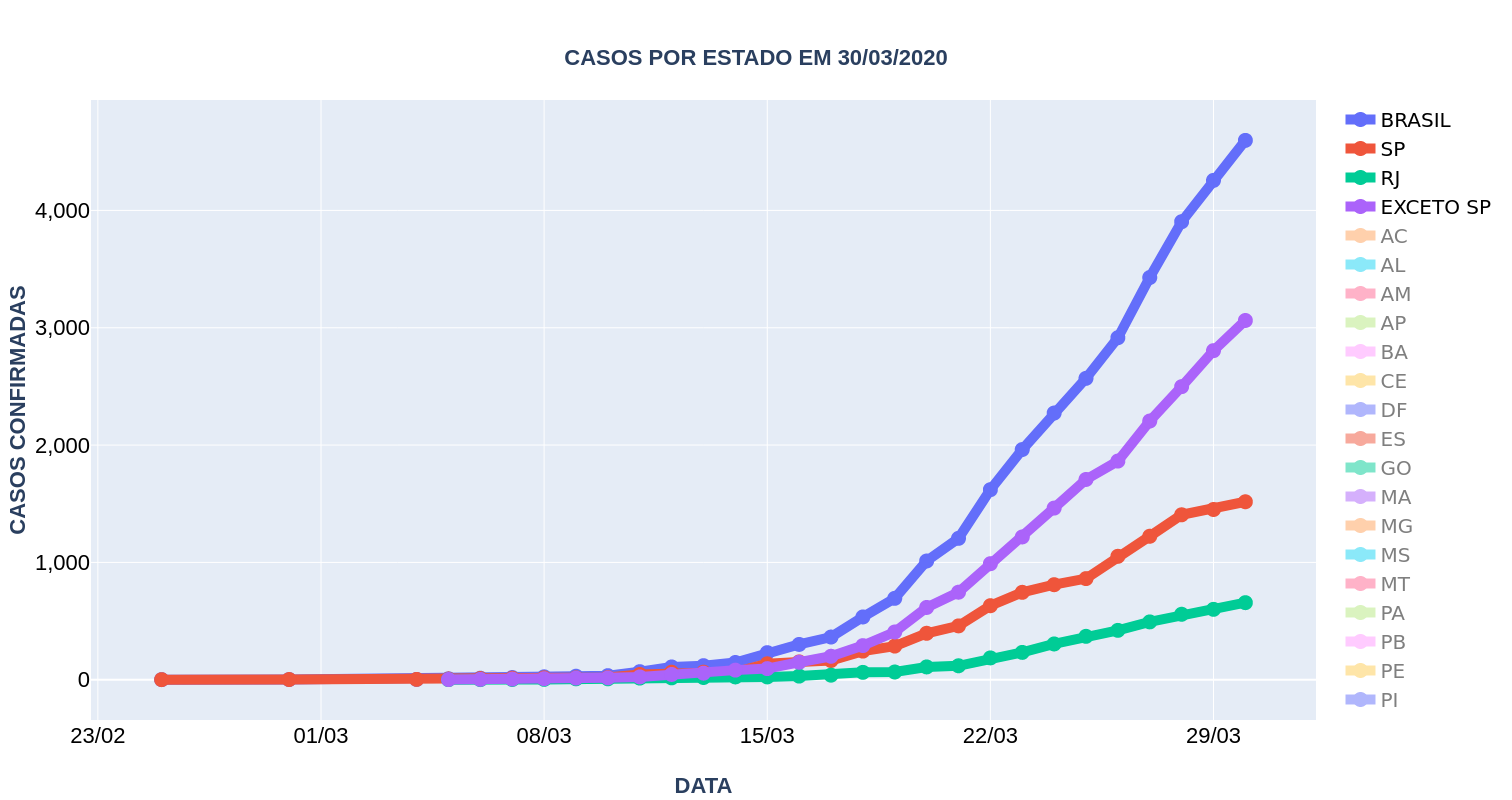

In [53]:
fig

## MAPS

In [54]:
maps = gpd.read_file('../../mapas_brasil/municipios-ibge/brasil-municipios.shp')
ufs = gpd.read_file('../../mapas_brasil/estados-ibge/BRUFE250GC_SIR.shp')

In [55]:
df = pd.read_csv('https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities.csv', dtype={'ibgeID':str})
municipios = pd.read_csv('../data/br_municipios_ibge.csv', dtype={'geocodigo':str})

cols = ['ibgeID','state','city','nome_uf','nome_mesorregiao','nome_municipio','totalCases']
dd = pd.merge(df,municipios, left_on='ibgeID', right_on='geocodigo', how = 'left')[cols]

final = pd.merge(dd,maps, left_on='ibgeID', right_on='CD_GEOCMU', how='left').drop(['CD_GEOCMU','NM_MUNICIP'],1)

In [56]:
final =  final[final['geometry'].notnull()]
final = gpd.GeoDataFrame(final)
final.crs = {'init' :'epsg:4326'}

rename_cols = {'nome_municipio':'Município','nome_uf':'Estado','totalCases':'Casos'}
final = final.rename(columns=rename_cols)

In [57]:
mask = df_states['date'] == max(df_states['date'])
estados = df_states[mask]


ff = final[['state','Estado']].drop_duplicates()
estados = pd.merge(estados,ff,on='state', how='inner')

estados['NM_ESTADO'] = estados['Estado'].str.upper()
estados = pd.merge(estados,ufs, on = 'NM_ESTADO')

estados = gpd.GeoDataFrame(estados)
estados.crs = {'init' :'epsg:4326'}

In [58]:
rename_cols = {'confirmed':'Casos','deaths':'Mortes','new_cases':'Novos Casos','new_deaths':'Novas Mortes','date':'Data'}
estados = estados.rename(columns=rename_cols)

In [59]:
estados.tail(1)

,Data,state,Casos,Novos Casos,Mortes,Novas Mortes,city,Estado,NM_ESTADO,NM_REGIAO,CD_GEOCUF,geometry
26,2020-03-30,RS,241,15,3,1,RS,Rio Grande do Sul,RIO GRANDE DO SUL,SUL,43,"POLYGON ((-53.03183 -27.15947, -53.02991 -27.15951, -53.02793 -27.15914, -53.02615 -27.15862, -5..."


In [60]:
from scripts import maps_vis
mymap =  maps_vis.get_map(final,'Casos', estados)

mymap.save('../maps/cidades_estados.html')
mymap.save('../../sample_pages/images/covid19/maps/cidades_estados.html')

In [61]:
from scripts import io

io.to_storage(bucket_folder='covid_maps',
              file_name='cidades_estados.html',
              path_to_file='../maps/cidades_estados.html')

Done!


,obitos,faixa
4,76,60+
3,6,40 a 59
2,3,20 a 39
0,0,0 a 9
1,0,10 a 19


In [77]:


# title  = 'Óbitos por Faixa Etária'
# x_name = 'Óbitos'
# y_name = 'Faixa Etária'

# trace = go.Bar(
#     orientation='h',
#     x = df['obitos'],
#     y = df['faixa']
# )

# data = [trace]

# layout = go.Layout(
#     barmode='stack',
    
#     yaxis_title=y_name,
#     yaxis = dict(
#         tickfont=dict(
#             size=22,
#             color='black',
#         ),
#     ),
#     xaxis_title=x_name,
#     xaxis = dict(
#         tickfont=dict(
#             size=22,
#             color='black',
#         ),
# #         font = dict(size=20)

#     ),
    
#     font=dict(
#             size=25,
#         ),

#     width  = 800,
#     height = 800,
# )

# fig = go.Figure(data=data, layout=layout)
# fig